# **Imports**

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

# **Load Dataset**

In [3]:
!unzip ./data/mobile_price.zip -d ./data/

Archive:  ./data/mobile_price.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [5]:
mobile_price_dataset = pd.read_csv("./data/train.csv")

In [6]:
X = mobile_price_dataset.drop('price_range', axis=1).values
y = mobile_price_dataset['price_range'].values

# **Split**

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

# **Preprocess**

## Convert to tensor

In [8]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_valid = torch.FloatTensor(x_valid)
y_valid = torch.LongTensor(y_valid)

## Standardization

In [9]:
mu = torch.mean(x_train, dim=0) #[n_sample,n_fea]
std = torch.std(x_train, dim=0) 

x_train = (x_train - mu)/std
x_valid = (x_valid - mu)/std

# **Dataloader**

## Train

In [10]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Validation

In [11]:
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# **Model**

In [70]:
num_features = 20
num_classes = 4
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_features, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_classes),
                      )

model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

# **Loss & Optimizer**

In [71]:
loss_fn = nn.CrossEntropyLoss()

In [72]:
# optimizer = optim.SGD(model.parameters(),
#                       lr=0.001)

# optimizer = optim.SGD(model.parameters(),
#                       lr=0.001,
#                       momentum=0.9)

# optimizer = optim.SGD(model.parameters(),
#                       lr=0.001,
#                       momentum=0.9,
#                       nesterov=True)

# optimizer = optim.RMSprop(model.parameters(),
#                           lr=0.001,
#                           alpha=0.99)

optimizer = optim.Adam(model.parameters(),
                       lr=0.001,
                       betas=(0.9, 0.999))

# **Device**

In [73]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = model.to(device)

# **Utils**

In [74]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

# **Train Loooop**

In [75]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

num_epochs = 300

for epoch in range(num_epochs):
  # Train
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_classes)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs, targets)

  loss_train_hist.append(loss_train.avg)
  acc_train_hist.append(acc_train.compute())

  # Validation
  model.eval()
  loss_valid = AverageMeter()
  acc_valid = Accuracy(task='multiclass', num_classes=num_classes)
  with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets)

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute())

  if epoch % 10 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Accuracy = {acc_train.compute():.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Accuracy = {acc_valid.compute():.4}')
    print()

Epoch 0
Train: Loss = 1.384, Accuracy = 0.2607
Valid: Loss = 1.354, Accuracy = 0.3733

Epoch 10
Train: Loss = 0.2863, Accuracy = 0.9436
Valid: Loss = 0.3165, Accuracy = 0.905

Epoch 20
Train: Loss = 0.09811, Accuracy = 0.9871
Valid: Loss = 0.2044, Accuracy = 0.91

Epoch 30
Train: Loss = 0.04884, Accuracy = 0.9971
Valid: Loss = 0.2067, Accuracy = 0.8983

Epoch 40
Train: Loss = 0.02629, Accuracy = 0.9993
Valid: Loss = 0.2114, Accuracy = 0.9

Epoch 50
Train: Loss = 0.01563, Accuracy = 1.0
Valid: Loss = 0.2304, Accuracy = 0.9017

Epoch 60
Train: Loss = 0.009564, Accuracy = 1.0
Valid: Loss = 0.2526, Accuracy = 0.9

Epoch 70
Train: Loss = 0.006374, Accuracy = 1.0
Valid: Loss = 0.2662, Accuracy = 0.9017

Epoch 80
Train: Loss = 0.00436, Accuracy = 1.0
Valid: Loss = 0.2852, Accuracy = 0.9033

Epoch 90
Train: Loss = 0.003147, Accuracy = 1.0
Valid: Loss = 0.3016, Accuracy = 0.905

Epoch 100
Train: Loss = 0.002347, Accuracy = 1.0
Valid: Loss = 0.316, Accuracy = 0.9017

Epoch 110
Train: Loss = 0.00

# **Plot**

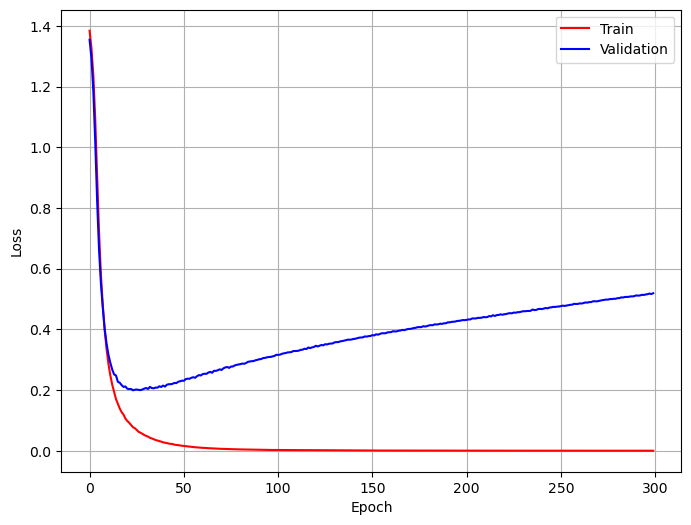

In [77]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

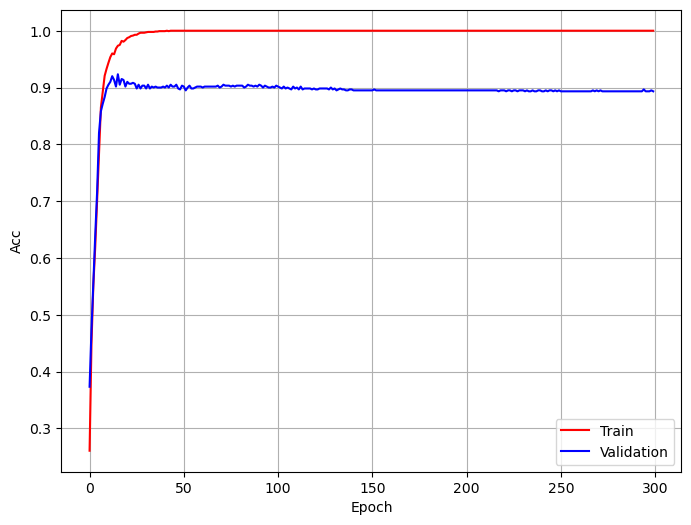

In [78]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Save**

In [25]:
!mkdir ./out/

In [79]:
optimizer_name = 'adam'

torch.save(torch.tensor(acc_train_hist),
           f'./out/{optimizer_name}-acc-train.pt')
torch.save(torch.tensor(acc_valid_hist),
           f'./out/{optimizer_name}-acc-valid.pt')

torch.save(torch.tensor(loss_train_hist),
           f'./out/{optimizer_name}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist),
           f'./out/{optimizer_name}-loss-valid.pt')

# **Comparison**

In [82]:
def plot_lcs(x:str, y:str):
  plt.figure(figsize=(8, 6))
  #
  for optim in ['sgd', 'sgd-m', 'sgd-m-nesterov', 'rms', 'adam']:
    z = torch.load(f'./out/{optim}-{x}-{y}.pt')
    #
    plt.plot(range(num_epochs), z, label=optim)
    plt.xlabel('epoch')
    plt.ylabel(f'{x} {y}')
    plt.grid(True)
    plt.legend()

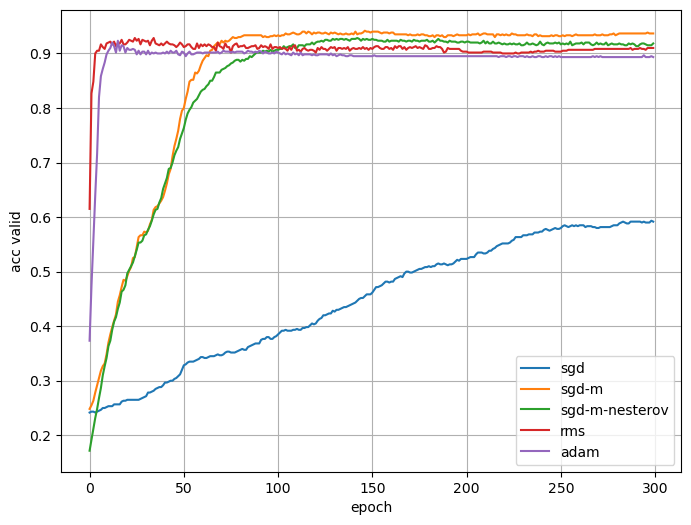

In [88]:
plot_lcs('acc', 'valid')